# MSE Breakdown
This looks at how the lapse rate and free troposphere temperature gradient cause $h(x)$ to differ from $\overline{h}$

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.convection import lapse_moist, equivalent_potential_temp
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import L_v, c_p, R, radius_earth, rot_earth, g
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.calculus import grad_x, grad_y
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-03-01 10:53:43,449 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'ucomp', 'height', 'vcomp', 'ps', 'sphum']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
sigma_levels = np.asarray(namelist['vert_coordinate_nml']['bk'])         # make first value the surface
# Sigma levels are at half pressure levels, so need to convolve to get pressure at full pressure levels.
sigma_levels = np.convolve(sigma_levels, np.ones(2)/2, 'valid')

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [145]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)
pressure_ft_ind = int(np.abs(ds[0].pfull-pressure_ft).argmin())
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH

def get_summer_ds(dataset):
    ds_nh_summer = isca_tools.utils.annual_time_slice(dataset, summer_months['nh']).sel(lat=slice(0, 90))  
    ds_sh_summer = isca_tools.utils.annual_time_slice(dataset, summer_months['sh']).sel(lat=slice(-90, 0)) 
    # Combine hemispheres and average over longitude, time and latitude.
    return xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')

# season = 'all'
season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

# Use zhang definition of extratropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
region = 'extratropics'
lat_min = 40
lat_max = 65
# lat_min = 80
# lat_max = 88

ds_all = []
ds_z_ft = []         # keep 'lon' and 'time' separate for z at ft level so can compute gradient
ind_surf = 0
ind_ft = 1
# ds_sigma_correction = []        # need pressure levels either side of p_ft to compute gradient wrt pressure
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        # ds_use = ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))
        # Keep all latitudes, so can do geostrophic wind calc without large gap between hemispheres
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))    
        # ds_sigma_correction += [ds_use.isel(pfull=[pressure_ft_ind-1, pressure_ft_ind, pressure_ft_ind+1]
        #                                     ).stack(lon_time=("lon","time"), 
        #                                             create_index=False).chunk(dict(lon_time=-1))[['vcomp', 'height', 'temp', 'ucomp']].load()]
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')
        ds_z_ft += [ds_use.height.isel(pfull=ind_ft).transpose('lat', 'lon', 'time').load()]     # make time the last index
        
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        if season == 'summer':
            ds_use = get_summer_ds(ds_use)
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
sigma_level_ft = sigma_levels[pressure_ft_ind]
# sigma_levels_use = sigma_levels[:len(ds_all[0].pfull)]      # Not all sigma levels are kept

n_lat = ds_all[0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine
lat_keep_ind = np.where((np.abs(ds_z_ft[0].lat) <= lat_max) & (np.abs(ds_z_ft[0].lat) >= lat_min))[0]
# Only keep used latitudes for sigma correction
# ds_sigma_correction = [ds_sigma_correction[i].isel(lat=lat_keep_ind) for i in range(n_exp)]

100%|██████████| 2/2 [00:23<00:00, 11.88s/it]


In [146]:
# Sanity check that way of reshaping ds_z_ft is consitent with lon_time coordinate
if season == 'summer':
    print(float(np.abs(get_summer_ds(ds_z_ft[0]).isel(lat=lat_keep_ind).to_numpy().reshape(n_lat, -1) - ds_all[0].height[ind_ft]).max()))
else:
    print(float(np.abs(ds_z_ft[0].isel(lat=lat_keep_ind).to_numpy().reshape(n_lat, -1) - ds_all[0].height[ind_ft]).max()))

0.0


## Get Data as a function of near-surface temperature percentile
Here I obtain data for the MSE breakdown conditioned on a given temperature percentile.

In [147]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

temp_mean = np.zeros((n_exp, 2, n_lat))         # second index: 0 is free trop, 1 is surface
z_mean = np.zeros((n_exp, 2, n_lat))
mse_mean = np.zeros((n_exp, 2, n_lat))
lapse_mean = np.zeros((n_exp, n_lat))
lapse_adiabat_mean = np.zeros((n_exp, n_lat))
temp_adiabat_mean = np.zeros((n_exp, n_lat))         # second index: 0 is free trop, 1 is surface

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_exp, 2, n_lat, n_quant))
# upper troposphere geopotential height as function of T percentile
z_quant3 = np.zeros((n_exp, 2, n_lat, n_quant))
# Surface pressure
p_surface_quant3 = np.zeros((n_exp, n_lat, n_quant))
mse_quant3 = np.zeros((n_exp, 2, n_lat, n_quant))  
lapse_quant3 = np.zeros((n_exp, n_lat, n_quant))
lapse_adiabat_quant3 = np.zeros((n_exp, n_lat, n_quant))
temp_adiabat_quant3 = np.zeros((n_exp, n_lat, n_quant))

def lambda_adiabat_fit_func(temp_ft, mse_surf, z_ft):
    # Adiabatic FT temperature is such that surf MSE equals free trop MSE
    return moist_static_energy(temp_ft, sphum_sat(temp_ft, pressure_ft_actual), z_ft) - mse_surf


ds_use = ds_z_ft[0].copy(deep=True)
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], ds_all[i].height[ind_surf])
        mse_ft = moist_static_energy(ds_all[i].temp[ind_ft], sphum_sat(ds_all[i].temp[ind_ft], pressure_ft_actual), ds_all[i].height[-1])
        mse_mean[i, ind_surf] = mse.mean(dim='lon_time')
        mse_mean[i, ind_ft] = mse_ft.mean(dim='lon_time')
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')       # surface temp at both pressure levels
        z_mean[i] = ds_all[i].height.mean(dim='lon_time')      
        lapse_mean[i] = -((ds_all[i].temp[ind_ft]-ds_all[i].temp[ind_surf])/(ds_all[i].height[ind_ft]-ds_all[i].height[ind_surf])).mean(dim='lon_time')
        # Reshape so can take average on day corresponding to given quantile
        for k in range(n_lat):
            temp_adiabat_mean[i, k] = scipy.optimize.fsolve(lambda_adiabat_fit_func, 273, args=(mse_mean[i, ind_surf, k], z_mean[i, ind_ft, k]))
            lapse_adiabat_mean[i, k] = -(temp_adiabat_mean[i, k]-temp_mean[i, ind_surf, k])/(z_mean[i, ind_ft, k]-z_mean[i, ind_surf, k])
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[ind_surf, k], quant, 0.5, 0.5)
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time', skipna=True)  
                z_quant3[i, :, k, j] = ds_all[i].height[:, k, use_ind].mean(dim='lon_time', skipna=True)  
                mse_quant3[i, ind_surf, k, j] = mse[k, use_ind].mean(dim='lon_time')
                mse_quant3[i, ind_ft, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                p_surface_quant3[i, k, j] = ds_all[i].ps[k, use_ind].mean(skipna=True)   
                lapse_quant3[i, k, j] = -((ds_all[i].temp[ind_ft]-ds_all[i].temp[ind_surf])/(ds_all[i].height[ind_ft]-ds_all[i].height[ind_surf]))[k, use_ind].mean(skipna=True)     
                temp_adiabat_quant3[i, k, j] = scipy.optimize.fsolve(lambda_adiabat_fit_func, 273, args=(mse_quant3[i, ind_surf, k, j], 
                                                                                                  z_quant3[i, ind_ft, k, j]))
                lapse_adiabat_quant3[i, k, j] = -(temp_adiabat_quant3[i, k, j]-temp_quant3[i, ind_surf, k, j]
                                                  )/(z_quant3[i, ind_ft, k, j] - z_quant3[i, ind_surf, k, j])
                pbar.update(1)

100%|██████████| 3564/3564 [00:43<00:00, 82.85it/s]


### CQE Evaluation
In the theory, we assume convective-quasi equilibrium. Below I consider the quantity $\epsilon(x) = h(x) - h_{FT}^*(x)$ to see if this is valid.

If convection was entirely setting the profile, then the lapse rate would be the moist adiabat, $\Gamma_a$.

It can be shown that $\epsilon(x) \approx (c_p + L_v \alpha(x) q^*(x))z(x)\Delta \Gamma_a(x)$
where $\Delta \Gamma_a(x) = \Gamma(x) - \Gamma_a(x)$, and $\alpha$ and $q^*$ are evaluated at $T_{FT}(x)$.

This is shown by the dashed lines. 

Because $\Delta \Gamma_a(x)$ is very large for low percentiles (as WTG is setting the FT temperature, as seem shortly), the squared term in the expansion is also important: $L_v \frac{\alpha(x)q^*(x)}{2T_{FT}(x)}(\alpha(x)T_{FT}(x) - 2)z(x)^2\Delta \Gamma_a(x)^2$
This is included in the faint dashed line.

We can simplify this equation by replacing the prefactor terms with their mean values i.e.
$\epsilon(x) \approx (c_p + L_v \overline{\alpha} \overline{q^*})\overline{z}\Delta \Gamma_a(x) + \left(L_v \frac{\overline{\alpha}\overline{q^*}}{2\overline{T_{FT}}}(\overline{\alpha}\overline{T_{FT}} - 2)\overline{z}^2\Delta \Gamma_a(x)^2\right)$

This simplification is shown by the dotted line and is pretty good.

In the mean, the squared term is not important and we have:
$\overline{\epsilon} \approx (c_p + L_v \overline{\alpha} \overline{q^*})\overline{z}\Delta \overline{\Gamma_a}$
where $\Delta \overline{\Gamma_a} = \overline{\Gamma} - \overline{\Gamma_a}$

From these equations, we see that if the lapse rate was the moist adiabat, $\Delta \Gamma_a(x) = 0$ and thus $\epsilon(x) = 0$. Clearly, this is not the case. In the simplification, the only factor varying with $x$ is $\Gamma_a(x)$. So the deviation of the lapse rate from the moist adiabat must be responsible.

In [148]:
dev_lapse_ad = lapse_quant3 - lapse_adiabat_quant3              # diff of actual lapse from adiabat.
dev_lapse_ad_mean = np.expand_dims(lapse_mean - lapse_adiabat_mean, axis=-1)

# theory_temp uses adiabatic free troposphere temp rather than lapse rate
epsilon_theory_temp = -(c_p + L_v * clausius_clapeyron_factor(temp_quant3[:, ind_ft], pressure_ft_actual) * 
                        sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual)) * (temp_quant3[:, ind_ft] - temp_adiabat_quant3)/1000
# theory neglects surface geopotential height and uses lapse rates
alpha_quant = clausius_clapeyron_factor(temp_quant3[:, ind_ft], pressure_ft_actual)
q_ft_quant = sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual)
epsilon_theory = (c_p + L_v * alpha_quant * q_ft_quant) * (z_quant3[:, ind_ft]) * dev_lapse_ad/1000
epsilon_theory_squared_term = 0.5/1000 * L_v * (z_quant3[:, ind_ft] * dev_lapse_ad)**2 * alpha_quant * q_ft_quant / temp_quant3[:, ind_ft] * (temp_quant3[:, ind_ft] * alpha_quant - 2)

alpha_mean = np.expand_dims(clausius_clapeyron_factor(temp_mean[:, ind_ft], pressure_ft_actual), axis=-1)
q_ft_mean = np.expand_dims(sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual), axis=-1)

prefactor_epsilon_simple = (c_p + L_v * alpha_mean * q_ft_mean) * z_mean[:, ind_ft][:, :, np.newaxis]/1000
epsilon_theory_simple = prefactor_epsilon_simple * dev_lapse_ad
epsilon_theory_simple_squared_term = 0.5/1000 * L_v * (z_mean[:, ind_ft][:, :, np.newaxis] * dev_lapse_ad)**2 * alpha_mean * q_ft_mean / temp_mean[:, ind_ft][:, :, np.newaxis] * (temp_mean[:, ind_ft][:, :, np.newaxis] * alpha_mean - 2)

epsilon_theory_mean = prefactor_epsilon_simple.squeeze() * dev_lapse_ad_mean.squeeze()

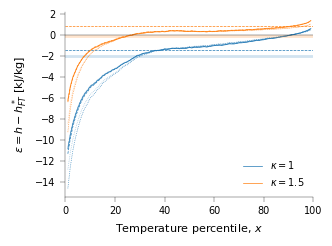

In [149]:
percentile_label = 'Temperature percentile, $x$'

save_epsilon_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, np.average(mse_quant3[i, ind_surf] - mse_quant3[i, ind_ft], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    for j, line_alpha in enumerate([0.5, 1]):
        ax.plot(quant_plot, np.average(epsilon_theory[i]+(1-j)*epsilon_theory_squared_term[i], axis=0, weights=lat_weights),
                color=default_colors[i], linestyle='--', alpha=line_alpha)
        ax.plot(quant_plot, np.average(epsilon_theory_simple[i]+(1-j)*epsilon_theory_simple_squared_term[i], axis=0, weights=lat_weights),
                color=default_colors[i], linestyle=':', alpha=line_alpha)
    ax.axhline(np.average(mse_mean[i, ind_surf] - mse_mean[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
    ax.axhline(np.average(epsilon_theory_mean[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle='--')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel('$\epsilon = h-h^*_{FT}$ [kJ/kg]')
ax.legend()
ax.set_xlim(0, 100)
if save_fig or save_epsilon_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/epsilon_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### WTG Evaluation
In the theory, we assume weak temperature gradient . Below I consider the quantity $\mu(x) = h_{FT}^*(x) - \overline{h_{FT}^*}$ to see if this is valid.

Using the approximation $\kappa(x) = \frac{z_{FT}}{T_{FT}} \approx \overline{\kappa} + 0.5 \left(\frac{\Gamma(x)}{\overline{\Gamma}}-1\right)\overline{\Gamma}\overline{\kappa}^2$, we can obtain the approximation:
$\mu \approx \frac{g\overline{z}^2}{2\overline{T_{FT}}}(\Delta \Gamma_a(x) - \Delta \overline{\Gamma_a} + \Delta \Gamma_A) + (c_p + L_v \overline{\alpha} \overline{q^*} + g \frac{\overline{z}}{\overline{T_{FT}}})\Delta T_{FT}(x)$
where $\Delta \Gamma_A = \Gamma_a(x) - \overline{\Gamma_a}$.

This approximation is pretty good as shown by the dashed line below. I split it up into a lapse rate term (first on RHS), shown by the dot-dashed line and a WTG term (second on RHS), shown by the dotted line. Clearly, the deviation of $\mu$ from 0 is dominated by the WTG term.

Interestingly, if WTG was correct, $\Delta T_{FT}=0$ but $\mu \neq 0$. If the profile was also convective for all days, $\Delta \Gamma_a(x) = \Delta \overline{\Gamma} = 0$ (changes in surface temperature would cause this to vary), but we wouldn't have $\Delta \Gamma_A = 0$ so $\mu \neq 0$ still.


In [150]:
dev_lapse_ad = lapse_quant3 - lapse_adiabat_quant3              # diff of actual lapse from adiabat.
dev_lapse_ad_mean = np.expand_dims(lapse_mean - lapse_adiabat_mean, axis=-1)
dev_lapse_ad2 = lapse_adiabat_quant3 - np.expand_dims(lapse_adiabat_mean, axis=-1)       # diff of adiabat on day x from on mean
dev_temp_ft = temp_quant3[:, ind_ft] - np.expand_dims(temp_mean[:, ind_ft], axis=-1)

prefactor_mu_lapse = 0.5 * g * np.expand_dims(z_mean[:, ind_ft]/temp_mean[:, ind_ft] * z_mean[:, ind_ft], axis=-1) / 1000
mu_theory_lapse = prefactor_mu_lapse * (dev_lapse_ad - dev_lapse_ad_mean + dev_lapse_ad2)
prefactor_mu_wtg = (c_p + L_v * alpha_mean * q_ft_mean + g * np.expand_dims(z_mean[:, ind_ft]/temp_mean[:, ind_ft], axis=-1)) / 1000
mu_theory_wtg = prefactor_mu_wtg * dev_temp_ft
mu_theory = mu_theory_lapse + mu_theory_wtg

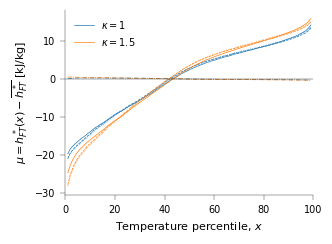

In [151]:
save_mu_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, np.average(mse_quant3[i, ind_ft] - mse_mean[i, ind_ft][:, np.newaxis], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(mu_theory[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle='--')
    ax.plot(quant_plot, np.average(mu_theory_wtg[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle=':')
    ax.plot(quant_plot, np.average(mu_theory_lapse[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle='-.')
    
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel('$\mu = h^*_{FT}(x) - \overline{h^*_{FT}}$ [kJ/kg]')
ax.legend()
ax.set_xlim(0, 100)

if save_fig or save_mu_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mu_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Surface MSE Distribution
We can combine the above equations for $\epsilon$ and $\mu$ to understand why at the surface, $h(x) \neq \overline{h}$ as we might expect if both WTG and convection were fully active.

$h(x) - \overline{h} = \epsilon(x) - \overline{\epsilon} + \mu(x)$

Using our simpler linear version of $\epsilon$, we can split this up into a lapse rate and WTG contribution:
$h(x) - \overline{h} \approx \left(c_p + L_v \overline{\alpha} \overline{q^*} + \frac{g\overline{z}}{2\overline{T_{FT}}}\right)\overline{z}(\Delta \Gamma_a(x) - \Delta \overline{\Gamma_a}) + \frac{g\overline{z}^2}{2\overline{T_{FT}}}\Delta \Gamma_A + (c_p + L_v \overline{\alpha} \overline{q^*} + g \frac{\overline{z}}{\overline{T_{FT}}})\Delta T_{FT}(x)$

It is clear that the lapse term dominates the variation for cold days and the WTG term dominates for hot days.

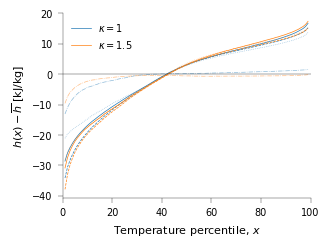

In [160]:
save_dev_h_surf_fig = False
# Choose which version of epsilon to use
# epsilon_theory_use = epsilon_theory
epsilon_theory_use = epsilon_theory_simple
# epsilon_theory_use = epsilon_theory_simple + epsilon_theory_simple_squared_term
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, np.average(mse_quant3[i, ind_surf] - mse_mean[i, ind_surf][:, np.newaxis], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(epsilon_theory_use[i] - epsilon_theory_mean[i][:, np.newaxis] + mu_theory[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle='--')
    ax.plot(quant_plot, np.average(mu_theory_wtg[i], axis=0, weights=lat_weights),
            color=default_colors[i], linestyle=':', alpha=0.5)
    ax.plot(quant_plot, np.average(epsilon_theory_use[i] - epsilon_theory_mean[i][:, np.newaxis] + mu_theory_lapse[i], 
                                   axis=0, weights=lat_weights), color=default_colors[i], linestyle='-.', alpha=0.5)
    
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel('$h(x) - \overline{h}$ [kJ/kg]')
ax.legend()
ax.set_xlim(0, 100)

if save_fig or save_dev_h_surf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/dev_h_surf_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\delta h(x)$ Contributions

Below, I look at how changes to WTG and lapse rate (CQE) contribute to why $\delta h(x) \neq \delta \overline{h}$. For low $x$, they seem to cancel each other out. But for high $x$, they seem to reinforce each other.

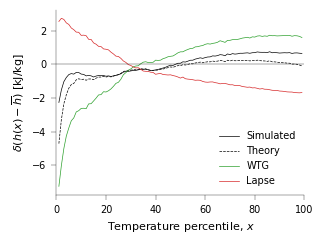

In [159]:
save_delta_h_surf_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average(np.diff(mse_quant3[:, ind_surf] - mse_mean[:, ind_surf][:, :, np.newaxis], axis=0)[0], 
                               axis=0, weights=lat_weights), color='k', label='Simulated')
ax.plot(quant_plot, np.average(np.diff(epsilon_theory_use - epsilon_theory_mean[:, :, np.newaxis] + mu_theory, axis=0)[0], axis=0,
                               weights=lat_weights), color='k', linestyle='--', label='Theory')
ax.plot(quant_plot, np.average(np.diff(mu_theory_wtg, axis=0)[0], axis=0, weights=lat_weights),
        color=default_colors[2], label='WTG')
ax.plot(quant_plot, np.average(np.diff(epsilon_theory_use - epsilon_theory_mean[:, :, np.newaxis] + mu_theory_lapse, axis=0)[0], 
                               axis=0, weights=lat_weights), color=default_colors[3], label='Lapse')
ax.set_ylabel('$\delta (h(x) - \overline{h})$ [kJ/kg]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.legend()
ax.set_xlim(0, 100)

if save_fig or save_delta_h_surf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_h_surf_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 100.0)

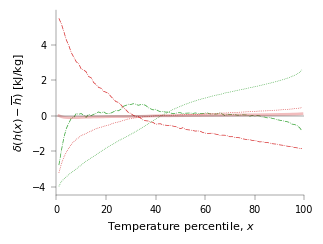

In [154]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average(np.diff(prefactor_mu_wtg, axis=0)[0] * dev_temp_ft[0], axis=0, weights=lat_weights), 
        color=default_colors[2], linestyle=':')
ax.plot(quant_plot, np.average(prefactor_mu_wtg[0] * np.diff(dev_temp_ft,axis=0).squeeze(), axis=0, weights=lat_weights), 
        color=default_colors[2], linestyle='-.')
ax.plot(quant_plot, np.average(np.diff(prefactor_epsilon_simple + prefactor_mu_lapse, axis=0)[0] * (dev_lapse_ad-dev_lapse_ad_mean)[0],
                               axis=0, weights=lat_weights), color=default_colors[3], linestyle=':')
ax.plot(quant_plot, np.average((prefactor_epsilon_simple + prefactor_mu_lapse)[0] * np.diff(dev_lapse_ad-dev_lapse_ad_mean,axis=0).squeeze(), 
                               axis=0, weights=lat_weights), color=default_colors[3], linestyle='-.')
ax.plot(quant_plot, np.average(np.diff(prefactor_mu_lapse * dev_lapse_ad2, axis=0)[0], 
                               axis=0, weights=lat_weights), color=default_colors[3], linestyle='-', alpha=0.3, lw=2)
ax.set_ylabel('$\delta (h(x) - \overline{h})$ [kJ/kg]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.legend()
ax.set_xlim(0, 100)

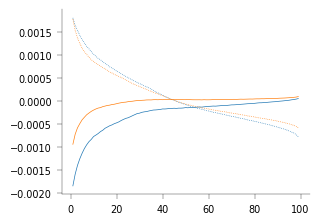

In [155]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, np.average(dev_lapse_ad[i], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(dev_lapse_ad2[i], axis=0, weights=lat_weights),
            color=default_colors[i], label=f'$\kappa={tau_lw[i]}$', linestyle=':')

### Checking at pressure levels as well as sigma.
Isca outputs data at $\sigma = p/p_s$ levels. Here, I account for the variation of surface pressure, $p_s$, by obtaining the variables on a given pressure level.

To find a variable, $\Phi$, at pressure $p$ from the value at $\sigma$, I use:
$\Phi(p) = \Phi(\sigma) + (p - \sigma p_s)\frac{\partial \Phi}{\partial p}(\sigma)$

It doesn't appear to make much difference though.

In [156]:
# Obtain quantile data but at pressure_ft_actual, rather than at a sigma level

# # quant2 is the actual quantile value rather than the average above a given quantile
# temp_p_quant3 = np.zeros((n_exp, n_lat, n_quant))
# # upper troposphere geopotential height as function of T percentile
# z_p_quant3 = np.zeros((n_exp, n_lat, n_quant))
# # upper troposphere zonal wind as function of temperature percentile
# # u_quant3 = np.zeros((n_exp, n_lat, n_quant))
# # upper troposphere meridional wind as function of temperature percentile
# v_p_quant3 = np.zeros((n_exp, n_lat, n_quant))
# u_p_quant3 = np.zeros((n_exp, n_lat, n_quant))
# 
# temp_p_mean = np.zeros((n_exp, n_lat)) 
# z_p_mean = np.zeros((n_exp, n_lat))
# 
# with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
#     for i in range(n_exp):
#         p_diff = pressure_ft_actual - sigma_level_ft * ds_all[i].ps     # difference sigma level pressure and a given pressure
#         temp_grad = p_diff * np.gradient(ds_sigma_correction[i].temp, ds_sigma_correction[i].pfull*100, axis=0)[1]
#         z_grad = p_diff * np.gradient(ds_sigma_correction[i].height, ds_sigma_correction[i].pfull*100, axis=0)[1]
#         v_grad = p_diff * np.gradient(ds_sigma_correction[i].vcomp, ds_sigma_correction[i].pfull*100, axis=0)[1]
#         u_grad = p_diff * np.gradient(ds_sigma_correction[i].ucomp, ds_sigma_correction[i].pfull*100, axis=0)[1]
#         
#         temp_p_mean[i] = (ds_all[i].temp[0]+temp_grad).mean(dim='lon_time')       # surface temp at both pressure levels
#         z_p_mean[i] = (ds_all[i].height[0]+z_grad).mean(dim='lon_time')      
#         for k in range(n_lat):
#             for j, quant in enumerate(quant_plot):
#                 use_ind = get_quant_ind(ds_all[i].temp[1, k], quant, 0.5, 0.5)
#                 temp_p_quant3[i, k, j] = (ds_all[i].temp[0] + temp_grad)[k, use_ind].mean(dim='lon_time', skipna=True)  
#                 z_p_quant3[i, k, j] = (ds_all[i].height[0] + z_grad)[k, use_ind].mean(skipna=True)      
#                 v_p_quant3[i, k, j] = v_func((ds_all[i].vcomp[0] + v_grad)[k, use_ind]).mean(skipna=True)       
#                 u_p_quant3[i, k, j] = u_func((ds_all[i].ucomp[0] + u_grad)[k, use_ind]).mean(skipna=True)   
#                 pbar.update(1)

## $\kappa = z_{500}/T_{500}$
Here, I look at the $z$ factor and how it changes with near-surface temperature percentile $x$. The factor is important for obtaining a useful equation for $\lambda_2(x)$ and simplifying it by assuming the wind is geostrophic and stays constant with warming.

The first plot below shows the computation of $\kappa$ using three different methods.
Equations 11 and 12 in Zhang 2023 can be combined to give the equation for $\kappa(x)$ as:
$$\kappa(x) = \frac{[1 + \overline{\Gamma} \frac{\overline{z}}{\overline{T}}]^{\frac{\Gamma(x)}{\overline{\Gamma}}}-1}{\Gamma(x)}$$
where $\Gamma=-dT/dz$ is the lapse rate.

The *Fixed lapse* method assumes $\Gamma(x) = \overline{\Gamma}$ so the above equation reduces to $\kappa = \frac{\overline{z}}{\overline{T}}$ and is constant for all $x$.

The *Varying lapse* method computes the lapse rate for each $x$ and uses the full equation.

The *Empirical* method finds $\kappa$ through a straight line fit to $z(x)$ vs $T(x)$ using data from both simulations ($\tau=1$ and $\tau=1.5$). In the top plot below, I only use the data points marked with crosses ($x>30$) to compute this empirical value. Because I combine simulations, this $\kappa$ stays constant with warming unlike the other methods. There is also an intercept, $C$, that I find empirically so $z(x)$ can be predicted empirically through: $z(x) = \kappa T(x) + C$.

In the bottom plot below, I show the difference between the $\tau=1$ and $\tau=1.5$ simulations in $z(x)$ and the prediction using each of the methods above i.e. $\delta z(x) = \kappa_{\tau=1.5}(x)T_{\tau=1.5}(x) - \kappa_{\tau=1}(x)T_{\tau=1}(x)$. For the empirical method, this reduces to $\delta z(x) = \kappa\delta T(x)$.

In [157]:
def get_kappa(z_mean, temp_mean, lapse_mean, lapse_x):
    """
    Returns the analytical ratio between z(x) and T(x) assuming varying lapse rate with x.
    
    Args:
        z_mean: [n_lat]
            Mean geopotential height at 500hPa for each latitude.
        temp_mean: [n_lat]
            Mean temperature at 500hPa for each latitude.
        lapse_mean: [n_lat]
            Mean lapse rate (-dT/dz) between surface and 500hPa for each latitude.
        lapse_x: [n_lat x n_quant]
            Lapse rate (-dT/dz) between surface and 500hPa for each latitude, conditioned on each near-surface temperature quantile x.
    Returns:
        [n_lat x n_quant]
            Ratio between z(x) and T(x) for each latitude, conditioned on each near-surface temperature quantile x.
    """
    z_mean = np.expand_dims(z_mean, axis=1)
    temp_mean = np.expand_dims(temp_mean, axis=1)
    lapse_mean = np.expand_dims(lapse_mean, axis=1)
    return ((1+lapse_mean * (z_mean/temp_mean))**(lapse_x/lapse_mean)-1) / lapse_x

kappa_lapse = np.asarray([get_kappa(z_mean[i], temp_mean[i, 0], lapse_mean[i], lapse_quant3[i]) for i in range(n_exp)])
kappa_quant3 = np.asarray([z_quant3[i] / temp_quant3[i, 0] for i in range(n_exp)])
kappa_mean = np.asarray([np.expand_dims(z_mean[i]/temp_mean[i, 0], axis=-1) for i in range(n_exp)])

ValueError: operands could not be broadcast together with shapes (2,18,18) (18,99) 

In [ ]:
kappa_quant_ind_thresh = 30         # Use all days larger than this x to fit kappa
kappa_empirical, intercept = np.polyfit(np.concatenate([np.average(temp_quant3[0, 0], weights=lat_weights, axis=0)[kappa_quant_ind_thresh:], 
                                              np.average(temp_quant3[1, 0], weights=lat_weights, axis=0)[kappa_quant_ind_thresh:]]), 
                              np.concatenate([np.average(z_quant3[0], weights=lat_weights, axis=0)[kappa_quant_ind_thresh:], 
                                              np.average(z_quant3[1], weights=lat_weights, axis=0)[kappa_quant_ind_thresh:]]),
                              deg=1)
labels_kappa = ['Fixed lapse', 'Varying lapse', 'Empirical']
linestyles_kappa = [':', '--', '-.']

save_z_vs_temp_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar))
for i in range(n_exp):
    ax[0].scatter(np.average(temp_quant3[i, 0], weights=lat_weights, axis=0)[kappa_quant_ind_thresh:], 
                  np.average(z_quant3[i], weights=lat_weights, axis=0)[kappa_quant_ind_thresh:], 
                  marker='x', alpha=0.2, s=50, color=default_colors[i])
    ax[0].scatter(np.average(temp_quant3[i, 0], weights=lat_weights, axis=0)[:kappa_quant_ind_thresh], 
                  np.average(z_quant3[i], weights=lat_weights, axis=0)[:kappa_quant_ind_thresh], 
                  marker='.', alpha=0.2, s=30, color=default_colors[i])
    ax[0].plot(np.average(temp_quant3[i, 0], weights=lat_weights, axis=0), 
              np.average(kappa_mean[i]*temp_quant3[i, 0], weights=lat_weights, axis=0), color=default_colors[i], linestyle=':')
    ax[0].plot(np.average(temp_quant3[i, 0], weights=lat_weights, axis=0), 
          np.average(kappa_lapse[i]*temp_quant3[i, 0], weights=lat_weights, axis=0), color=default_colors[i], linestyle='--')
ax[0].plot(np.arange(200, 300), kappa_empirical*np.arange(200, 300) + intercept, color='k', lw=ax_linewidth, linestyle='-.')

ax[1].scatter(np.average(temp_quant3[1, 0]-temp_quant3[0, 0], weights=lat_weights, axis=0)[kappa_quant_ind_thresh:], 
              np.average(z_quant3[1]-z_quant3[0], weights=lat_weights, axis=0)[kappa_quant_ind_thresh:], 
              marker='x', alpha=0.2, s=50, color='k')
ax[1].scatter(np.average(temp_quant3[1, 0]-temp_quant3[0, 0], weights=lat_weights, axis=0)[:kappa_quant_ind_thresh], 
              np.average(z_quant3[1]-z_quant3[0], weights=lat_weights, axis=0)[:kappa_quant_ind_thresh], 
              marker='.', alpha=0.2, s=30, color='k')
for i, kappa_use in enumerate([kappa_mean, kappa_lapse, np.asarray([kappa_empirical]*n_exp)]):
    ax[1].plot(np.average(temp_quant3[1, 0]-temp_quant3[0, 0], weights=lat_weights, axis=0), 
               np.average(kappa_use[1]*temp_quant3[1, 0]-kappa_use[0]*temp_quant3[0, 0], weights=lat_weights, axis=0), 
               color='k', lw=ax_linewidth, label=labels_kappa[i], linestyle=linestyles_kappa[i])
ax[1].legend()
ax[0].set_xlim(240, 275)
ax[0].set_ylim(5400, 6050)
ax[1].set_xlim(5.5, 8.2)
ax[1].set_ylim(110, 165)
ax[0].set_xlabel('$T$ [K]')
ax[0].set_ylabel('$z$ [m]')
ax[1].set_xlabel('$\delta T$ [K]')
ax[1].set_ylabel('$\delta z$ [m]')
plt.tight_layout()

if save_fig or save_z_vs_temp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/z_vs_temp.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Comparison of $z(x)$ and $\delta z(x)$
Below is similar to above, but I change the x-axis to be the near-surface temperature percentile, $x$.

The plots show that the *Varying lapse* method is best overall at matching the simulated thick lines. However, if we ignore the coldest days (when convection is not active), the *Empirical* method is best.

In the bottom plot, for the *Fixed lapse* and *Varying lapse* methods, I plot in black the full $\delta z(x) = \kappa_{\tau=1.5}(x)T_{\tau=1.5}(x) - \kappa_{\tau=1}(x)T_{\tau=1}(x)$.

In grey though, I plot the sum of the linear terms in the taylor series i.e. $\delta z(x) = \kappa_{\tau=1}(x) \delta T(x) + T_{\tau=1}(x) \delta \kappa(x)$. The two match up pretty well indicating that the non-linear $\delta T(x) \delta \kappa(x)$ term is not that important.

In [ ]:
save_z_quant_fig = False
plot_include_p = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2 * width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(z_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\tau={tau_lw[i]}$', 
               lw=2, alpha=0.5)
    for j, kappa_use in enumerate([kappa_mean, kappa_lapse, np.asarray([kappa_empirical]*n_exp)]):
        ax[0].plot(quant_plot, np.average(kappa_use[i] * temp_quant3[i, 0], axis=0, weights=lat_weights) + 
                   (1 if j==len(linestyles_kappa)-1 else 0)*intercept, color='k', linestyle=linestyles_kappa[j])
    ax[0].axhline(np.average(z_mean[i], axis=0, weights=lat_weights), color=default_colors[i], lw=ax_linewidth, alpha=0.5)
    if plot_include_p:
        ax[0].plot(quant_plot, np.average(z_p_quant3[i], axis=0, weights=lat_weights), color='green', alpha=0.4)
        ax[0].plot(quant_plot, np.average(np.expand_dims(z_p_mean[i]/temp_p_mean[i], axis=-1) * temp_p_quant3[i], axis=0, weights=lat_weights), 
                color='green', linestyle=':', alpha=0.4)
ax[1].plot(quant_plot, np.average(z_quant3[1]-z_quant3[0], axis=0, weights=lat_weights), color='k', lw=2, alpha=0.5)
for i, kappa_use in enumerate([kappa_mean, kappa_lapse, np.asarray([kappa_empirical]*n_exp)]):
    ax[1].plot(quant_plot, np.average(kappa_use[1] * temp_quant3[1, 0] - 
                                      kappa_use[0] * temp_quant3[0, 0], axis=0, weights=lat_weights), 
            color='k', linestyle=linestyles_kappa[i], label=labels_kappa[i])
    if i < len(linestyles_kappa)-1:
        # Plot sum of linear taylor series terms to see if it matches up
        ax[1].plot(quant_plot, np.average(kappa_use[0]*(temp_quant3[1, 0] - temp_quant3[0, 0]) + 
                                          (kappa_use[1]-kappa_use[0])*temp_quant3[0, 0],
                                          axis=0, weights=lat_weights), color='k', linestyle=linestyles_kappa[i], alpha=0.2)
if plot_include_p:
    ax[1].plot(quant_plot, np.average(z_p_quant3[1]-z_p_quant3[0], axis=0, weights=lat_weights), color='green', alpha=0.4)
    ax[1].plot(quant_plot, np.average(np.expand_dims((z_p_mean[1]-z_p_mean[0])/(temp_p_mean[1]-temp_p_mean[0]), axis=-1) * 
                                      (temp_p_quant3[1] - temp_p_quant3[0]), axis=0, weights=lat_weights), 
               color='green', linestyle=':', alpha=0.4)
ax[1].axhline(np.average(z_mean[1]-z_mean[0], axis=0, weights=lat_weights), color='k', lw=ax_linewidth, alpha=0.5)
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$z$ [m]')
ax[1].set_ylabel('$\delta z$ [m]')
ax[1].set_xlabel('Near surface temperature percentile, $x$')
plt.tight_layout()

if save_fig or save_z_quant_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/z_quant.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Comparison of $\kappa(x)$
For the *Fixed lapse* and *Varying lapse* methods, I can compute $\kappa$ for each simulation. Clearly if we include the varying lapse rate, we get a much better match to the simulated thick line.

For the *Empirical method*, we have a non-zero intercept so $z(x) = \kappa T(x) + C$ so the $\kappa$ value can not be directly compared. It is included as the dot-dash line at $\delta \kappa=0$ in the $\delta \kappa$ plot though as both $C$ and $\kappa$ stay constant with this method.

In [ ]:
save_kappa_quant_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(kappa_quant3[i], weights=lat_weights, axis=0), color=default_colors[i], lw=2, alpha=0.5)
    ax[0].axhline(np.average(kappa_mean.squeeze()[i], weights=lat_weights, axis=0), color=default_colors[i], 
                  linestyle=linestyles_kappa[0], label=labels_kappa[0] if i==0 else None)
    ax[0].plot(quant_plot, np.average(kappa_lapse[i], weights=lat_weights, axis=0), color=default_colors[i], 
               linestyle=linestyles_kappa[1], label=labels_kappa[1] if i==0 else None)
    # Don't include empirical as relies on interecept so kappa is not really comparable.
ax[1].plot(quant_plot, np.average(kappa_quant3[1]-kappa_quant3[0], weights=lat_weights, axis=0), color='k', lw=2, alpha=0.5)
ax[1].axhline(np.average(kappa_mean.squeeze()[1]-kappa_mean.squeeze()[0], weights=lat_weights, axis=0), 
              color='k', linestyle=linestyles_kappa[0])
ax[1].plot(quant_plot, np.average(kappa_lapse[1]-kappa_lapse[0], weights=lat_weights, axis=0), color='k',
           linestyle=linestyles_kappa[1])
ax[1].axhline(0, linestyle=linestyles_kappa[2], color='k')
ax[0].set_xlim(0, 100)
ax[0].legend()
ax[0].set_ylabel('$\kappa$ [mK$^{-1}$]')
ax[1].set_ylabel('$\delta \kappa$ [mK$^{-1}$]')
ax[-1].set_xlabel('Near surface temperature percentile, $x$')
plt.tight_layout()

if save_fig or save_kappa_quant_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/kappa_quant.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Contributions to $\delta z(x)$
If we take the linear taylor series, we can approximate $\delta z(x) = \kappa_{\tau=1}(x) \delta T(x) + T_{\tau=1}(x) \delta \kappa(x)$.

Below, the first term, $\kappa_{\tau=1}(x) \delta T(x)$, is shown by a dashed line and the second term, $T_{\tau=1}(x) \delta \kappa(x)$, is shown by a dotted line. For the empirical method, this second term is zero as $\kappa$ is calculated by combining the $\tau=1$ and $\tau=1.5$ simulations.

It is interesting that the first term $\kappa_{\tau=1}(x) \delta T(x)$ is basically the same for the *Fixed lapse* and *Varying lapse* methods. However, the second term provides a significant difference, especially for cold days (small $x$).

The light grey lines show the simulated taylor series factors i.e. the grey and black solid lines would be exactly the same if the non-linear $\delta T(x) \delta \kappa(x)$ term was exactly zero.

In [ ]:
save_delta_z_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
ax = [ax]
ax[0].plot(quant_plot, np.average(z_quant3[1]-z_quant3[0], axis=0, weights=lat_weights), color='k', label='Simulated')
for i, kappa_use in enumerate([kappa_mean, kappa_lapse, np.asarray([kappa_empirical]*n_exp), kappa_quant3]):
    use_color = 'k' if i == 3 else default_colors[i]
    ax[0].plot(quant_plot, np.average(kappa_use[0]*(temp_quant3[1, 0] - temp_quant3[0, 0]), axis=0, weights=lat_weights), 
               color=use_color, linestyle='--', alpha=0.2 if i==3 else 1)
    ax[0].plot(quant_plot, np.average((kappa_use[1]-kappa_use[0])*temp_quant3[0, 0], axis=0, weights=lat_weights), 
               color=use_color, linestyle=':', alpha=0.2 if i==3 else 1)
    ax[0].plot(quant_plot, np.average(kappa_use[0]*(temp_quant3[1, 0] - temp_quant3[0, 0]) + 
                                      (kappa_use[1]-kappa_use[0])*temp_quant3[0, 0], axis=0, weights=lat_weights), 
               color=use_color, label=None if i==3 else labels_kappa[i], alpha=0.2 if i==3 else 1)

ax[0].scatter(1, np.average(z_mean[1]-z_mean[0], axis=0, weights=lat_weights), color='k', alpha=0.8, marker='o',linewidth=0)
use_color = [default_colors[0], default_colors[2]]
use_alpha = [1, 1]
for i, kappa_use in enumerate([kappa_mean.squeeze(), np.asarray([kappa_empirical]*n_exp)]):
    ax[0].scatter(1, np.average(kappa_use[0]*(temp_mean[1, 0] - temp_mean[0, 0]), axis=0, weights=lat_weights), 
                  color=use_color[i], alpha=use_alpha[i], marker='x')
    ax[0].scatter(1, np.average(temp_mean[0, 0]*(kappa_use[1] - kappa_use[0]), axis=0, weights=lat_weights), 
                  color=use_color[i], alpha=use_alpha[i], marker='o', lw=0.5, facecolors='none', linewidth=0.5)
    ax[0].scatter(1, np.average(kappa_use[0]*(temp_mean[1, 0] - temp_mean[0, 0]) + 
                                temp_mean[0, 0]*(kappa_use[1] - kappa_use[0]), axis=0, weights=lat_weights), 
                  color=use_color[i], alpha=0.8, marker='o',linewidth=0)

ax[0].set_xlim(0, 100)
ax[0].legend()
ax[0].set_ylabel('$\delta z$ [m]')
ax[-1].set_xlabel('Near surface temperature percentile, $x$')
plt.tight_layout()

if save_fig or save_delta_z_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_z_decomp.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Lapse Rate Changes
The second term is related to changes in $\delta \kappa(x)$ and from the equation for $\kappa(x)$ must be dominated by changes in lapse rate, $\delta \Gamma$. 

In the bottom left plot below, we see there is a large decrease in $\delta \Gamma$ for $x<30$ coinciding with the large contribution from the $\delta \kappa$ term for the *Varying lapse* method above.

The picture here is shown more clearly by the moist static energy lapse rate, $\Gamma_h=\frac{h^*_{FT}(x)-h(x)}{z_{FT}(x) - z(x)}$, on the right. $\Gamma_h=0$ for a convectively stable profile along the moist adiabat and becomes negative for a convectively unstable profile where $h(x)>h^*_{FT}(x)$.

For $x<30$, convective becomes more active with warming and so shifts towards $\Gamma_h=0$. The smaller $x$, the more positive $\Gamma_h$ in the $\tau=1$ simulation so the larger the permitted $\delta \Gamma_h$.

For $x>30$, $\delta \Gamma_h$ is small because convection provides a limit on how much it cann decrease. I.e. it can't decrease to such an extent that $\Gamma_h$ becomes very negative as it would be convectively unstable.

The fact that $\Gamma_h$ becomes negative means that some about of convective instability is permitted. We should look into why this is, but it may be a competition between local convection and large scale circulation, possibly an anticyclone which pushes the profile to become unstable. 

In [ ]:
save_lapse_rate_fig = False
fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0, 0].plot(quant_plot, np.average(lapse_quant3[i]*1000, weights=lat_weights, axis=0), color=default_colors[i])
    # Convert MSE into kelvin per km units as well
    ax[0, 1].plot(quant_plot, np.average(lapse_mse_quant3[i]*1000/c_p*1000, weights=lat_weights, axis=0), color=default_colors[i])
ax[1, 0].plot(quant_plot, np.average((lapse_quant3[1]-lapse_quant3[0])*1000, weights=lat_weights, axis=0), color='k')
ax[1, 1].plot(quant_plot, np.average((lapse_mse_quant3[1]-lapse_mse_quant3[0])*1000/c_p*1000, weights=lat_weights, axis=0), color='k')
ax[0, 1].axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylabel('Lapse rate, $\Gamma = -dT/dz$ [K/km]')
ax[0, 1].set_ylabel('$\Gamma_h = dh/dz$ [K/km]')
ax[1, 0].set_ylabel('$\delta \Gamma$ [K/km]')
ax[1, 1].set_ylabel('$\delta \Gamma_h$ [K/km]')
fig.supxlabel('Near surface temperature percentile, $x$', fontsize=7)
plt.tight_layout()

if save_fig or save_lapse_rate_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lapse_rate.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\lambda_2$ Analysis assuming $\delta v_g = 0$

$\lambda_2 = \frac{\delta h_{FT}^*(x)}{\delta \overline{h_{FT}^*}} = \frac{[c_p + L_v\alpha(x)q^*(x)]\delta T(x) + g\delta z(x)}{[c_p + L_v\overline{\alpha q^*}]\delta \overline{T} + g\delta \overline{z}}$

Writing $z = \kappa T$ and assuming non-linear terms $\delta T \delta \kappa = 0$, we can re-write this as:

$\lambda_2 \approx \frac{[g + \frac{c_p + L_v\alpha(x)q^*(x)}{\kappa(x)}] \delta z(x) - [c_p + L_v\alpha(x)q^*(x)]\frac{T(x)}{\kappa(x)}\delta \kappa(x)}{[g + \frac{c_p + L_v\overline{\alpha q^*}}{\overline{\kappa}}] \delta \overline{z} -[c_p + L_v\overline{\alpha q^*}]\frac{\overline{T}}{\overline{\kappa}}\delta \overline{\kappa}}$

If we were to assume that in both the numerator and denominator the $\delta z$ term is much larger than the $\delta \kappa$ term, then we get:
$\lambda_2 \approx \frac{[g + \frac{c_p + L_v\alpha(x)q^*(x)}{\kappa(x)}]}{[g + \frac{c_p + L_v\overline{\alpha q^*}}{\overline{\kappa}}]} \times \frac{\delta z(x)}{\delta \overline{z}}$

And the assumption $\delta z(x) = const = \delta \overline{z}$ is consistent with $\delta v_g = 0$ hence the link to the geostrophic wind. If we assume this, $\frac{\delta z(x)}{\delta \overline{z}} \approx 1$ and $\lambda_2$ can be calculated with just the climatological term.

So to assess this simplification of $\lambda_2$, we need to assess two sets of approximations.
1. $\delta z >> \delta \kappa$: In the $\delta h_{FT}^*$ equations, do the $\delta z$ term dominate the $\delta \kappa$ term?
2. $\delta z(x) = \delta \overline{z}$: Does the geopotential height distribution change equally across the temperature distribution with warming, as we expect from constant geostrophic wind?


In [ ]:
alpha_x = clausius_clapeyron_factor(temp_quant3[0, 0], pressure_ft_actual)
alpha_mean = clausius_clapeyron_factor(temp_mean[0, 0], pressure_ft_actual)
q_x = sphum_sat(temp_quant3[0, 0], pressure_ft_actual)
q_mean = sphum_sat(temp_mean[0, 0], pressure_ft_actual)
lambda_2_num = {}
lambda_2_denom = {}
lambda_2_num['sim'] = (c_p + L_v * alpha_x * q_x) * (temp_quant3[1, 0] - temp_quant3[0, 0]) + g * (
            z_quant3[1] - z_quant3[0])
labels_use = ['taylor', 'mean', 'lapse', 'empirical']
for i, kappa_use in enumerate([kappa_quant3, kappa_mean, kappa_lapse, np.asarray([kappa_empirical]*n_exp)]):
    lambda_2_num[labels_use[i] + '_z'] = (g + (c_p + L_v * alpha_x * q_x)/kappa_use[0]) 
    lambda_2_num[labels_use[i] + '_kappa'] = -(c_p + L_v * alpha_x * q_x) * (temp_quant3[0, 0]/kappa_use[0]) * (kappa_use[1] - kappa_use[0])
    # lambda_2_num[labels_use[i] + '_kappa'] = (-(c_p + L_v * alpha_mean * q_mean) * (temp_mean[0, 0]/kappa_mean[0].squeeze()))[:, np.newaxis] * (kappa_use[1] - kappa_use[0])
    lambda_2_num[labels_use[i]] = lambda_2_num[labels_use[i] + '_z'] * (z_quant3[1] - z_quant3[0]) + \
                                  lambda_2_num[labels_use[i] + '_kappa'] 

lambda_2_denom['sim'] = (c_p + L_v * alpha_mean * q_mean) * (temp_mean[1, 0] - temp_mean[0, 0]) + g * (
            z_mean[1] - z_mean[0])
for i, kappa_use in enumerate([kappa_mean.squeeze(), kappa_mean.squeeze(), kappa_mean.squeeze(), np.asarray([kappa_empirical]*n_exp)]):
    lambda_2_denom[labels_use[i] + '_z'] = (g + (c_p + L_v * alpha_mean * q_mean)/kappa_use[0])
    lambda_2_denom[labels_use[i] + '_kappa'] = -(c_p + L_v * alpha_mean * q_mean) * (temp_mean[0, 0]/kappa_use[0].squeeze()
                                                                       ) * (kappa_use[1] - kappa_use[0]).squeeze()
    lambda_2_denom[labels_use[i]] = lambda_2_denom[labels_use[i] + '_z']  * (z_mean[1] - z_mean[0]) + lambda_2_denom[labels_use[i] + '_kappa']

z_delta_ratio = (z_quant3[1] - z_quant3[0]) / (z_mean[1] - z_mean[0])[:, np.newaxis]    

### Approximation 1: $\delta z >> \delta \kappa$
Below I assess the first approximation.

In the top plot, the solid lines represent the numerator in the full $\lambda_2$ equation i.e. $\delta h_{FT}^*(x)$. The dashed line represents the $\delta z(x)$ term and the dotted line represents the $\delta \kappa(x)$ term for the various $\kappa$ methods. The grey line is to show the linear series is a good approximation.

The markers represent the denominator: filled circles are the full $\delta \overline{h_{FT}^*}$, crosses are the $\delta \overline{z}$ contribution and hollow circles are the $\delta \overline{\kappa}$ contribution.

In the bottom plot, the solid lines show how the numerators and denomenators in the top plot combine to give $\lambda_2$ when all terms are included. The dashed lines show the $\lambda_2$ approximation without the $\delta \kappa$ terms.

When we ignore the $\delta \kappa$ terms, all forms of $\kappa$ basically collapse onto a single line. This means that the estimation of $\kappa$ is only really important for the $\delta \kappa$ term. I.e. the fact that the varying lapse rate method is the best at capturing $\kappa$ only makes a difference if we include the $\delta \kappa$ terms.

Note by definition $\delta \kappa = 0$ for the empirical method, but it overestimates $\delta \overline{\kappa}$ and $\delta \kappa(x)$ for small $x$, leading to a not great estimate of $\lambda_2$.

So overall, it seems that this approximation is problematic - we can't really ignore the $\delta \kappa$ term.

In [ ]:
save_lambda_2_fig = False

use_color = ['k', 'grey', default_colors[0], default_colors[1], default_colors[2]]
labels_use = ['Simulated', None] + labels_kappa
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2 * width['one_col'] / ar), sharex=True)
for i, key in enumerate(['sim', 'taylor', 'mean', 'lapse', 'empirical']):
    ax[0].plot(quant_plot, np.average(lambda_2_num[key], weights=lat_weights, axis=0), color=use_color[i], 
               label=labels_use[i])
    ax[1].plot(quant_plot, np.average(lambda_2_num[key] / lambda_2_denom[key][:, np.newaxis], 
                                      weights=lat_weights, axis=0), color=use_color[i], 
               label='$\delta \kappa \\neq 0$' if key=='mean' else None)
    if key != 'sim':
        ax[0].plot(quant_plot, np.average(lambda_2_num[key+'_z'] * (z_quant3[1] - z_quant3[0]), weights=lat_weights, axis=0),
                   color=use_color[i], linestyle='--')
        ax[0].plot(quant_plot, np.average(lambda_2_num[key+'_kappa'], weights=lat_weights, axis=0),
                   color=use_color[i], linestyle=':')
        ax[1].plot(quant_plot, np.average((lambda_2_num[key+'_z'] / lambda_2_denom[key+'_z'][:, np.newaxis]) * z_delta_ratio, 
                                          weights=lat_weights, axis=0), color=use_color[i], linestyle='--', alpha=0.5, 
                   label='$\delta \kappa = 0$' if key=='mean' else None)
    if key in ['sim', 'mean', 'empirical']:
        ax[0].scatter(1, np.average(lambda_2_denom[key], weights=lat_weights, axis=0), color=use_color[i], marker='o', alpha=0.8, 
                   linewidth=0)
        if key != 'sim':
            ax[0].scatter(1, np.average(lambda_2_denom[key+'_z'] * (z_mean[1] - z_mean[0]), weights=lat_weights, axis=0), 
                          color=use_color[i], marker='x')
            ax[0].scatter(1, np.average(lambda_2_denom[key+'_kappa'], weights=lat_weights, axis=0), 
                          color=use_color[i], marker='o', facecolors='none', lw=0.5)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\delta h^*_{FT}$ [kJ/kg]')
ax[1].set_ylabel('$\lambda_2 = \delta h^*_{FT}(x) / \delta \overline{h^*_{FT}}$')
ax[1].set_xlabel('Near surface temperature percentile, $x$')
ax[0].legend()
ax[1].legend()

if save_fig or save_lambda_2_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_2.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Approximation 2: $\delta z(x) = \delta \overline{z}$
Below, the dashed lines show the estimates of $\lambda_2$ excluding the $\delta \kappa$ terms. The dotted lines show the estimates if we further assume $\delta z(x) = \delta \overline{z}$. It seems that this second approximation actually improves things. 

Again, we see that how $\kappa$ is computed is not important - all coloured lines collapse onto each other.

So it seems that the two approximations partially cancel out. I think we may have a slightly circular argument here as $\kappa$ and $z$ are related so the two assumptions are not independent.

In [ ]:
# Assuming delta kappa terms are zero and see what lambda looks like
labels_use = ['Simulated', None] + labels_kappa
save_lambda_2_fix_kappa_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
for i, key in enumerate(['sim', 'taylor', 'mean', 'lapse', 'empirical']):
    if key == 'sim':
        ax.plot(quant_plot, np.average(lambda_2_num[key] / lambda_2_denom[key][:, np.newaxis], weights=lat_weights, axis=0), 
                color=use_color[i], label=labels_use[i])
    else:
        ax.plot(quant_plot, np.average((lambda_2_num[key+'_z'] / lambda_2_denom[key+'_z'][:, np.newaxis]) * z_delta_ratio, 
                                       weights=lat_weights, axis=0), color=use_color[i], label=labels_use[i], linestyle='--')
        ax.plot(quant_plot, np.average((lambda_2_num[key+'_z'] / lambda_2_denom[key+'_z'][:, np.newaxis]), 
                                   weights=lat_weights, axis=0), linestyle=':', color=use_color[i])
ax.plot(quant_plot, np.average(z_delta_ratio, weights=lat_weights, axis=0), color='cyan', label='$\delta z / \delta \overline{z}$')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_ylabel('$\lambda_2 = \delta h^*_{FT}(x) / \delta \overline{h^*_{FT}}$')
ax.legend()
ax.set_xlabel('Near surface temperature percentile, $x$')
if save_fig or save_lambda_2_fix_kappa_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_2_fix_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Separating $\delta z$ and $\delta \kappa$ contributions to $\lambda_2$
Writing $\mu_z = g + (c_p + L_v\alpha q^*)/\kappa$ and $\mu_{\kappa} = (c_p + L_v\alpha q^*)T/\kappa$ such that $\mu_z = \mu_{\kappa}/T+g$, we can write $\lambda_2$ as:
$\lambda_2 = \frac{\mu_z(x)\delta z(x) - \mu_{\kappa}(x)\delta \kappa(x)}{\overline{\mu_z}\delta \overline{z} - \overline{\mu_{\kappa}}\delta \overline{\kappa}}$
The denominator is equivalent to $\overline{\mu_z}\delta \overline{z} \left[1 - \frac{\overline{\mu_{\kappa}}\delta \overline{\kappa}}{\overline{\mu_z}\delta \overline{z}}\right]$ or $-\overline{\mu_{\kappa}}\delta \overline{\kappa}\left[1 - \frac{\overline{\mu_z}\delta \overline{z}}{\overline{\mu_{\kappa}}\delta \overline{\kappa}}\right]$ so we can write:
$$\lambda_2 = \frac{\mu_z(x)}{\overline{\mu_z} \left[1 - \frac{\overline{\mu_{\kappa}}\delta \overline{\kappa}}{\overline{\mu_z}\delta \overline{z}}\right]}\frac{\delta z(x)}{\delta \overline{z}} + 
\frac{\mu_{\kappa}(x)}{\overline{\mu_{\kappa}}\left[1 - \frac{\overline{\mu_z}\delta \overline{z}}{\overline{\mu_{\kappa}}\delta \overline{\kappa}}\right]}\frac{\delta \kappa(x)}{\delta \overline{\kappa}}$$

This separates out the $\delta z(x)$ and $\delta \kappa(x)$ terms. Next we need to see if it can be further simplified.

Below I plot all the terms in this form of the equation for the actual and varying lapse rate $\kappa$ estimate:
* Solid line: full $\lambda_2$ 
* Dashed line: $\delta z(x)/\delta \overline{z}$ prefactor
* Dotted line: $\delta \kappa(x)/\delta \overline{\kappa}$ prefactor
* Dashed-dotted line: $\delta \kappa(x)/\delta \overline{\kappa}$

From this, we see that $\delta \kappa(x)/\delta \overline{\kappa}$ is over-estimated by the *Varying lapse* method, resulting in an over-estimate of $\lambda_2$ for low $x$ and the opposite for high $x$.

Looking at the dashed and dotted lines, the orange and black lines overlap almost exactly. This indicates that the way $\kappa$ is computed doesn't seem to affect the prefactors - just the $\delta \kappa(x)$ term. Hence we may be able to provide a simplification through the prefactors.

Also, the $\delta \kappa(x)/\delta \overline{\kappa}$ prefactor looks quite constant with $x$, suggesting we may be able to replace $\mu_{\kappa}(x)$ with $\overline{\mu_{\kappa}}$


In [ ]:
mu_z = {'x': {}, 'mean': {}}
mu_kappa = {'x': {}, 'mean': {}}
z_delta = {'x': (z_quant3[1] - z_quant3[0]), 'mean': (z_mean[1] - z_mean[0])}
kappa_delta = {'x': {}, 'mean': {}}
lambda_z_prefactor = {}
lambda_kappa_prefactor = {}
labels_use = ['taylor', 'mean', 'lapse', 'empirical']
for i, kappa_use in enumerate([kappa_quant3, kappa_mean, kappa_lapse, np.asarray([kappa_empirical]*n_exp)]):
    mu_z['x'][labels_use[i]] = (g + (c_p + L_v * alpha_x * q_x)/kappa_use[0]) 
    mu_kappa['x'][labels_use[i]] = (mu_z['x'][labels_use[i]] - g) * temp_quant3[0, 0]
    mu_z['mean'][labels_use[i]] = (g + (c_p + L_v * alpha_mean * q_mean)/kappa_mean[0].squeeze())
    mu_kappa['mean'][labels_use[i]] = (mu_z['mean'][labels_use[i]] - g) * temp_mean[0, 0]
    
    kappa_delta['x'][labels_use[i]] = kappa_use[1] - kappa_use[0]
    kappa_delta['mean'][labels_use[i]] = (kappa_mean[1] - kappa_mean[0]).squeeze()
    
for key in mu_z['x']:
    lambda_z_prefactor[key] = mu_z['x'][key]/mu_z['mean'][key][:, np.newaxis]
    lambda_z_prefactor[key] = lambda_z_prefactor[key] / (1-mu_kappa['mean'][key]/mu_z['mean'][key] * 
                                                         kappa_delta['mean'][key]/z_delta['mean'])[:, np.newaxis]
    lambda_kappa_prefactor[key] = mu_kappa['x'][key]/mu_kappa['mean'][key][:, np.newaxis]
    lambda_kappa_prefactor[key] = lambda_kappa_prefactor[key] / (1-mu_z['mean'][key]/mu_kappa['mean'][key] * 
                                                         z_delta['mean']/kappa_delta['mean'][key])[:, np.newaxis]

In [ ]:
use_color = ['k', 'grey', default_colors[1]]
labels_use = ['Simulated', None] + [labels_kappa[1]]

save_lambda_2_additive_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
ax.plot(quant_plot, np.average(lambda_2_num['sim'] / lambda_2_denom['sim'][:, np.newaxis], weights=lat_weights, axis=0), 
        color=use_color[0], label=labels_use[0])
for i, key in enumerate(['taylor', 'lapse']):
    ax.plot(quant_plot, np.average(lambda_z_prefactor[key] * z_delta['x'] / z_delta['mean'][:, np.newaxis] + 
                                   lambda_kappa_prefactor[key] * kappa_delta['x'][key] / kappa_delta['mean'][key][:, np.newaxis], 
                                   weights=lat_weights, axis=0), color=use_color[i+1], label=labels_use[i+1])
    ax.plot(quant_plot, np.average(lambda_z_prefactor[key], weights=lat_weights, axis=0), color=use_color[i+1], linestyle='--', alpha=0.5)
    if key != 'empirical':
        # Leave out empirical as get no delta kappa contribution
        ax.plot(quant_plot, np.average(lambda_kappa_prefactor[key], weights=lat_weights, axis=0), color=use_color[i+1], 
                linestyle=':', alpha=0.5)
    if key in ['taylor', 'lapse']:
        # delta kappa ratio is a function of x
        ax.plot(quant_plot, np.average(kappa_delta['x'][key] / kappa_delta['mean'][key][:, np.newaxis], weights=lat_weights, axis=0), color=use_color[i+1], linestyle='-.', lw=ax_linewidth)
    else:
        # delta kappa ratio is a constant
        ax.axhline(np.average(kappa_delta['x'][key] / kappa_delta['mean'][key][:, np.newaxis], weights=lat_weights, axis=0),
                   color=use_color[i+1], linestyle='-.', lw=ax_linewidth)
ax.plot(quant_plot, np.average(z_delta_ratio, weights=lat_weights, axis=0), color='cyan', label='$\delta z / \delta \overline{z}$',
        lw=ax_linewidth)    
ax.axhline(1, color='k', lw=ax_linewidth)
ax.axhline(0, color='k', lw=ax_linewidth)
ax.legend(frameon=True, framealpha=1, edgecolor='white', fontsize=6)
ax.set_xlim(0, 100)
ax.set_ylabel('$\lambda_2 = \delta h^*_{FT}(x) / \delta \overline{h^*_{FT}}$')
ax.set_xlabel('Near surface temperature percentile, $x$')

if save_fig or save_lambda_2_additive_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_2_additive.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda_2$ Approximations
From above, we see that $\delta \kappa(x)/\delta \overline{\kappa}$ is over-estimated by the *Varying lapse* method, resulting in an over-estimate of $\lambda_2$ for low $x$ and the opposite for high $x$.

Looking at the dashed and dotted lines, the orange and black lines overlap almost exactly. This indicates that the way $\kappa$ is computed doesn't seem to affect the prefactors - just the $\delta \kappa(x)$ term. Hence we may be able to provide a simplification through replacing $\kappa(x)$ with $\overline{\kappa}$. The very close match between the solid orange line and the dashed dark red line below shows that this approximation is very good. For all other dashed lines, I make this approximation too.

Also, the $\delta \kappa(x)/\delta \overline{\kappa}$ prefactor looks quite constant with $x$, suggesting we may be able to replace $\mu_{\kappa}(x)$ with $\overline{\mu_{\kappa}}$. The dashed dark red and orange lines are actually fairly different suggesting this approximation is not brilliant.

A taylor expansion of the denomenator of $\lambda_2$ can be performed in the parameter $\beta = \frac{\overline{\mu_{\kappa}}\delta \overline{\kappa}}{\overline{\mu_z}\delta \overline{z}}$, which is small - below 0.25 for the latitudes considered. Keeping just terms linear in $\beta$, we get:
$$\lambda_2 \approx (1+\beta)\frac{\mu_z(x)}{\overline{\mu_z}}\frac{\delta z(x)}{\delta \overline{z}} - \beta \frac{\mu_{\kappa}(x)}{\overline{\mu_{\kappa}}}\frac{\delta \kappa(x)}{\delta \overline{\kappa}$$

The close overlap between the dashed dark red and dashed light green lines below shows that this is a very good approximation. The light blue dashed line shows it is significantly worse if I further assume $\mu_{\kappa}(x) = \overline{\mu_{\kappa}}$. Neglecting $\beta$ altogether gives the dark blue dashed line which is worse still.

In [ ]:
def get_lambda2_prefactors(use_mean_kappa=False, set_mu_kappa_constant=False, do_beta_taylor=False, beta_method='full', 
                           ignore_g=False, use_mean_T=False):
    # Function to get lambda2 prefactors with various simplifications
    if beta_method == 'full':
        beta = (mu_kappa['mean']['mean']/mu_z['mean']['mean'] * kappa_delta['mean']['mean']/z_delta['mean'])[:, np.newaxis]
    elif beta_method == 'simple':
        beta = (temp_mean[0, 0] * kappa_delta['mean']['mean']/z_delta['mean'])[:, np.newaxis]
    elif beta_method == 'zero':
        beta = np.zeros_like(temp_mean[0, 0][:, np.newaxis])
    else:
        raise ValueError(f"Beta method indicated = {beta_method}.\nThis is not one of 'full', 'simple' or 'zero'")
        
    if ignore_g:
        g_factor = 0
    else:
        g_factor = g
        
    if use_mean_T or set_mu_kappa_constant:
        temp_x_use = temp_mean[0, 0][:, np.newaxis]
    else:
        temp_x_use = temp_quant3[0, 0]
        
    if use_mean_kappa:
        kappa_x_use = kappa_mean[0]
    else:
        kappa_x_use = kappa_quant3[0]
        
    mu_z_x = g_factor + (c_p + L_v * alpha_x * q_x)/kappa_x_use
    mu_z_mean = g_factor + (c_p + L_v * alpha_mean * q_mean)/kappa_mean[0].squeeze()
    
    if set_mu_kappa_constant:
        mu_kappa_x = (c_p + L_v * alpha_mean * q_mean)[:, np.newaxis] * temp_x_use/kappa_x_use
    else:
        mu_kappa_x = (c_p + L_v * alpha_x * q_x) * temp_x_use/kappa_x_use
    mu_kappa_mean = (c_p + L_v * alpha_mean * q_mean) * temp_mean[0, 0]/kappa_mean[0].squeeze()
    
    if do_beta_taylor:
        z_prefactor = (1 + beta) * mu_z_x / mu_z_mean[:, np.newaxis]
        kappa_prefactor = -beta * mu_kappa_x / mu_kappa_mean[:, np.newaxis]
    else:
        z_prefactor = mu_z_x / mu_z_mean[:, np.newaxis] / (1-beta)
        kappa_prefactor = mu_kappa_x / mu_kappa_mean[:, np.newaxis] / (1-1/beta)
    return z_prefactor, kappa_prefactor

In [ ]:
save_lambda_2_approx_fig = False
colors_approx = plt.cm.jet(np.linspace(0,1,6))[::-1]
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
ax.plot(quant_plot, np.average(lambda_2_num['sim'] / lambda_2_denom['sim'][:, np.newaxis], weights=lat_weights, axis=0), 
        color='k', label=labels_use[0])
for i, key in enumerate(['taylor', 'lapse']):
    ax.plot(quant_plot, np.average(lambda_z_prefactor[key] * z_delta['x'] / z_delta['mean'][:, np.newaxis] + 
                                   lambda_kappa_prefactor[key] * kappa_delta['x'][key] / kappa_delta['mean'][key][:, np.newaxis], 
                                   weights=lat_weights, axis=0), color='grey' if i==0 else default_colors[1], label=labels_use[i+1])

labels_approx = ['$\kappa(x)=\overline{\kappa}$', '$\mu_{\kappa}(x)=\overline{\mu_{\kappa}}$', 
                 'Taylor in $\\beta$ ($\mu_{\kappa}(x)\\neq\overline{\mu_{\kappa}}$)', 
                 'Taylor in $\\beta$ ($\mu_{\kappa}(x)=\overline{\mu_{\kappa}}$)', '$\delta \kappa(x)=0$']    
args_approx = [[True], [True, True], [True, False, True], [True, True, True], [True, True, True, 'zero']]

for i in range(len(labels_approx)):
    z_prefactor_use, kappa_prefactor_use = get_lambda2_prefactors(*args_approx[i])
    ax.plot(quant_plot, np.average(z_prefactor_use * z_delta['x'] / z_delta['mean'][:, np.newaxis] + 
                                   kappa_prefactor_use * kappa_delta['x']['lapse'] / kappa_delta['mean']['lapse'][:, np.newaxis], 
                                   weights=lat_weights, axis=0), color=colors_approx[i],
        label=labels_approx[i], linestyle='--')

ax.axhline(1, color='k', lw=ax_linewidth)
ax.legend(frameon=True, framealpha=1, edgecolor='white', fontsize=6)
ax.set_xlim(0, 100)
ax.set_ylabel('$\lambda_2 = \delta h^*_{FT}(x) / \delta \overline{h^*_{FT}}$')
ax.set_xlabel('Near surface temperature percentile, $x$')
if save_fig or save_lambda_2_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_2_approx.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\beta$ Approximation
The light green line above looks like a good approximation. If we further assume $\beta = \frac{\overline{\mu_{\kappa}}\delta \overline{\kappa}}{\overline{\mu_z}\delta \overline{z}} \approx \frac{\overline{T}\delta \overline{\kappa}}{\delta \overline{z}}$ (this is equivalent to assuming $c_p + L_v \overline{\alpha}\overline{q^*}>> g\overline{\kappa}$), we get:

$$\lambda_2 \approx (1+\frac{\overline{T}\delta \overline{\kappa}}{\delta \overline{z}})\frac{\mu_z(x)}{\overline{\mu_z}}\frac{\delta z(x)}{\delta \overline{z}} - \frac{\mu_{\kappa}(x)}{\overline{\mu_{\kappa}}}\frac{\overline{T} \delta \kappa(x)}{\delta \overline{z}}$$

And putting in the expressions for $\mu$ (always setting $\kappa(x) = \overline{\kappa}$):

$$\lambda_2 \approx (1+\frac{\overline{T}\delta \overline{\kappa}}{\delta \overline{z}})\frac{g \overline{\kappa} + c_p + L_v\alpha(x) q^*(x)}{g \overline{\kappa} + c_p + L_v\overline{\alpha} \overline{q^*}}\frac{\delta z(x)}{\delta \overline{z}} - 
\frac{c_p + L_v\alpha(x) q^*(x)}{c_p + L_v\overline{\alpha} \overline{q^*}}\frac{T(x) \delta \kappa(x)}{\delta \overline{z}}$$

This is shown by the cyan line below.

The $\beta$ simplification we made above is consistent with neglecting all the $g\overline{\kappa}$ terms, in which case we get:

$$\lambda_2 \approx (1+\frac{\overline{T}\delta \overline{\kappa}}{\delta \overline{z}})\frac{c_p + L_v\alpha(x) q^*(x)}{c_p + L_v\overline{\alpha} \overline{q^*}}\frac{\delta z(x)}{\delta \overline{z}} - 
\frac{c_p + L_v\alpha(x) q^*(x)}{c_p + L_v\overline{\alpha} \overline{q^*}}\frac{T(x) \delta \kappa(x)}{\delta \overline{z}}$$

This is shown by the blue line below.

We can also replace $T(x)$ with $\overline{T}$:

$$\lambda_2 \approx (1+\frac{\overline{T}\delta \overline{\kappa}}{\delta \overline{z}})\frac{c_p + L_v\alpha(x) q^*(x)}{c_p + L_v\overline{\alpha} \overline{q^*}}\frac{\delta z(x)}{\delta \overline{z}} - 
\frac{c_p + L_v\alpha(x) q^*(x)}{c_p + L_v\overline{\alpha} \overline{q^*}}\frac{\overline{T} \delta \kappa(x)}{\delta \overline{z}}$$

This is shown by the dashed dark blue line below.

In [ ]:
save_lambda_2_beta_approx_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
ax.plot(quant_plot, np.average(lambda_2_num['sim'] / lambda_2_denom['sim'][:, np.newaxis], weights=lat_weights, axis=0), 
        color='k', label=labels_use[0])
ax.plot(quant_plot, np.average(lambda_z_prefactor['lapse'] * z_delta['x'] / z_delta['mean'][:, np.newaxis] + 
                                   lambda_kappa_prefactor['lapse'] * kappa_delta['x']['lapse'] / kappa_delta['mean']['lapse'][:, np.newaxis], 
                                   weights=lat_weights, axis=0), default_colors[1], label=labels_use[2])

labels_beta_approx = ['Taylor in $\\beta$ ($\mu_{\kappa}(x)\\neq\overline{\mu_{\kappa}}$)', 
                      '$\\beta \\approx \\frac{\overline{T}\delta \overline{\kappa}}{\delta \overline{z}}$', 
                      '$g\overline{\kappa} \\approx 0$', '$T(x) \\approx \overline{T}$']    
args_beta_approx = [[True, False, True], [True, False, True, 'simple'], 
                    [True, False, True, 'simple', True], [True, False, True, 'simple', True, True]]

for i in range(len(labels_beta_approx)):
    z_prefactor_use, kappa_prefactor_use = get_lambda2_prefactors(*args_beta_approx[i])
    ax.plot(quant_plot, np.average(z_prefactor_use * z_delta['x'] / z_delta['mean'][:, np.newaxis] + 
                                   kappa_prefactor_use * kappa_delta['x']['lapse'] / kappa_delta['mean']['lapse'][:, np.newaxis], 
                                   weights=lat_weights, axis=0), color=colors_approx[2+i], label=labels_beta_approx[i], linestyle='--')

ax.axhline(1, color='k', lw=ax_linewidth)
ax.legend(fontsize=6)
ax.set_xlim(0, 100)
ax.set_ylabel('$\lambda_2 = \delta h^*_{FT}(x) / \delta \overline{h^*_{FT}}$')
ax.set_xlabel('Near surface temperature percentile, $x$')
if save_fig or save_lambda_2_beta_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_2_beta_approx.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Final Approximation
The dashed dark blue line above seems quite a good approximation to the solid orange line (it is actually closer to the solid black line than the solid orange line is, but this is due to a cancellation of errors). So below, I look at the different contributions to it.

The dashed lines ignore the prefactors.

In [ ]:
save_lambda_2_final_approx_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
ax.plot(quant_plot, np.average(lambda_2_num['sim'] / lambda_2_denom['sim'][:, np.newaxis], weights=lat_weights, axis=0), 
        color='k', label=labels_use[0])
z_prefactor_use, kappa_prefactor_use = get_lambda2_prefactors(*args_beta_approx[-1])
ax.plot(quant_plot, np.average(z_prefactor_use * z_delta['x'] / z_delta['mean'][:, np.newaxis] + 
                                   kappa_prefactor_use * kappa_delta['x']['lapse'] / kappa_delta['mean']['lapse'][:, np.newaxis], 
                                   weights=lat_weights, axis=0), color='k', label='Approximation', linestyle=':')
ax.plot(quant_plot, np.average(z_prefactor_use * z_delta['x'] / z_delta['mean'][:, np.newaxis], 
                                   weights=lat_weights, axis=0), color=default_colors[0], label='$z$ contribution')
ax.plot(quant_plot, np.average(z_delta['x'] / z_delta['mean'][:, np.newaxis], weights=lat_weights, axis=0), 
        color=default_colors[0], linestyle='--')
ax.plot(quant_plot, np.average(kappa_prefactor_use * kappa_delta['x']['lapse'] / kappa_delta['mean']['lapse'][:, np.newaxis], 
                                   weights=lat_weights, axis=0), color=default_colors[1], label='$\kappa$ contribution')
ax.plot(quant_plot, np.average(-temp_mean[0, 0][:, np.newaxis] * kappa_delta['x']['lapse'] / z_delta['mean'][:, np.newaxis], 
                               weights=lat_weights, axis=0), color=default_colors[1], linestyle='--')
ax.plot(quant_plot, np.average((c_p + L_v * alpha_x * q_x) / (c_p + L_v * alpha_mean * q_mean)[:, np.newaxis], weights=lat_weights, axis=0),
        color=default_colors[2], label='$\\frac{c_p + L_v\\alpha(x) q^*(x)}{c_p + L_v\overline{\\alpha} \overline{q^*}}$')
ax.scatter(1, np.average(1+temp_mean[0, 0] * kappa_delta['mean']['lapse'] / z_delta['mean'], weights=lat_weights, axis=0), 
           color=default_colors[0], marker='x', s=10)

ax.axhline(1, color='k', lw=ax_linewidth)
ax.legend(fontsize=6, loc='lower right')
ax.set_xlim(0, 100)
ax.set_ylabel('$\lambda_2 = \delta h^*_{FT}(x) / \delta \overline{h^*_{FT}}$')
ax.set_xlabel('Near surface temperature percentile, $x$')

if save_fig or save_lambda_2_final_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_2_final_approx.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\delta z$ and $\delta \Gamma$ contributions to $\delta T(x)$
The above is looking at the dynamic ($\delta z$) and thermodynamic $\delta \kappa$ contributions to $\lambda_2$. However, we want a theory for the change in near-surface temperature, $\delta T(x)$.

Linking the surface and 500hPa level, we can write the exact equation: $T(x) = z_{500}(x)\Gamma(x) +  T_{500}(x) = z_{500}\left(\Gamma(x) + \frac{1}{\kappa(x)}\right)$

Doing a binomial expansion, we can approximate $\kappa(x) \approx \overline{\kappa} + 0.5 \left(\frac{\Gamma(x)}{\overline{\Gamma}}-1\right)\overline{\Gamma}\overline{\kappa}^2$

Then doing a Taylor expansion, we get: $\frac{1}{\kappa(x)} \approx \frac{1}{\overline{\kappa}}\left(1 - \frac{\overline{\kappa}}{2}(\Gamma(x)-\overline{\Gamma})\right)$

Subbing in and using $\overline{\kappa} = \frac{\overline{z}}{\overline{T_{500}}} = \frac{\overline{z}}{\overline{T} - \overline{\Gamma}\overline{z}}$, we get:

$T(x) \approx \frac{z(x)}{\overline{z}}\overline{T} + \frac{1}{2}z(x)(\Gamma(x) - \overline{\Gamma})$

This is shown as the dashed line in the top plot below. It is a pretty good approximation. The dotted line using the $\kappa$ formula and no taylor expansion is shown by the dotted line.

Then from this, we get three terms in the $\delta T(x)$ equation: a change in the mean climate (dotted), a change in the lapse rate (dashed) and a change in the dynamics (dashed-dotted).

$\delta T(x) = \frac{z(x)}{\overline{z}}\delta \overline{T} + \frac{1}{2}\frac{z(x)}{\overline{z}}\delta (\overline{z}(\Gamma(x) - \overline{\Gamma})) + [\overline{T} + \frac{1}{2}\overline{z}(\Gamma(x) - \overline{\Gamma})] \delta \left(\frac{z(x)}{\overline{z}}\right)$


In [ ]:
save_delta_temp_theory_fig = False
temp_delta_theory_cont = {'T': z_quant3[0]/z_mean[0][:, np.newaxis] * (temp_mean[1, 1]-temp_mean[0, 1])[:, np.newaxis],
                   'lapse': 0.5 * z_quant3[0]/z_mean[0][:, np.newaxis] * np.diff(z_mean[:, :, np.newaxis] * (
                           lapse_quant3-lapse_mean[:, :, np.newaxis]), axis=0)[0], 
                   'z': (temp_mean[0, 1][:, np.newaxis] + 0.5 * z_mean[0][:, np.newaxis] * (lapse_quant3[0]-lapse_mean[0, :, np.newaxis])
                         ) * np.diff(z_quant3/z_mean[:, :, np.newaxis], axis=0)[0]}
temp_delta_theory_cont['all'] = temp_delta_theory_cont['T'] + temp_delta_theory_cont['lapse'] + temp_delta_theory_cont['z']
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2 * width['one_col'] / ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(temp_quant3[i, 1], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].plot(quant_plot, np.average(z_quant3[i]*(lapse_quant3[i]+1/kappa_quant3[i]), axis=0, weights=lat_weights), 
             color=default_colors[i], linestyle=':')
    ax[0].plot(quant_plot, np.average(z_quant3[i]*((temp_mean[i, 1]/z_mean[i])[:, np.newaxis] + 0.5*(lapse_quant3[i]+ - lapse_mean[i][:, np.newaxis])),
                                    axis=0, weights=lat_weights), color=default_colors[i], linestyle='--')
ax[0].legend(fontsize=5)
ax[0].set_ylabel('Near-surface Temperature, $T$ [K]')

ax[1].plot(quant_plot, np.average(temp_quant3[1, 1]-temp_quant3[0, 1], weights=lat_weights, axis=0), label='Simulated', color='r')
ax[1].plot(quant_plot, np.average(temp_delta_theory_cont['all'], weights=lat_weights, axis=0), color='k', label='Theory')
ax[1].plot(quant_plot, np.average(temp_delta_theory_cont['T'], weights=lat_weights, axis=0), color='k', linestyle=':', 
           label='$\delta \overline{T}$')
ax[1].plot(quant_plot, np.average(temp_delta_theory_cont['lapse'], weights=lat_weights, axis=0), color='k', linestyle='--', 
           label='$\delta \Gamma$')
ax[1].plot(quant_plot, np.average(temp_delta_theory_cont['z'], weights=lat_weights, axis=0), color='k', linestyle='-.', 
           label='$\delta z$')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(fontsize=5)
ax[1].set_ylabel('$\delta T$ [K]')
ax[1].set_xlabel('Near surface temperature percentile, $x$')
ax[0].set_xlim(0, 100)

if save_fig or save_delta_temp_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_temp_theory.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Geostrophic Winds
Below, I see if the geostrophic winds are a good approximation at the free troposphere level.

In [ ]:
save_v_geo_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(quant_plot, np.average(v_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(v_geo_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle=':')
    if plot_include_p:
        ax.plot(quant_plot, np.average(v_p_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], alpha=0.4, linestyle='--')
ax.set_xlim(0, 100)
ax.legend()
ax.set_ylabel('$|v|$ [m/s]' if take_abs_v else '$v$ [m/s]')
ax.set_xlabel('Near surface temperature percentile, $x$')
plt.tight_layout()

if save_fig or save_v_geo_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/v_geo.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [ ]:
save_u_geo_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(quant_plot, np.average(u_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax.plot(quant_plot, np.average(u_geo_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle=':')
    if plot_include_p:
        ax.plot(quant_plot, np.average(u_p_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], alpha=0.4, linestyle='--')
ax.set_xlim(0, 100)
ax.legend()
ax.set_ylabel('$|u|$ [m/s]' if take_abs_u else '$u$ [m/s]')
ax.set_xlabel('Near surface temperature percentile, $x$')
plt.tight_layout()

if save_fig or save_u_geo_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_geo.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Consider a single time, to see if geostrophic approximation is valid

In [ ]:
tau_ind_st = 0
time_ind_st = 1150
# time_ind_st = 1060
# pressure_ft_ind = int(np.abs(ds[0].pfull-300).argmin())
pressure_ft_ind_gradient_calc = [pressure_ft_ind-1, pressure_ft_ind, pressure_ft_ind+1]
ds_st = {}
ds_st['low'] = ds[tau_ind_st].isel(pfull=pressure_ft_ind_gradient_calc
                                   ).sel(time=time_ind_st, method='nearest')[['height', 'vcomp', 'ucomp', 'ps']].load()
ds_st['high'] = isca_tools.load_dataset('aquaplanet/high_res/').isel(pfull=pressure_ft_ind_gradient_calc
                                   ).sel(time=time_ind_st, method='nearest')[['height', 'vcomp', 'ucomp', 'ps']].load()
wind_sigma_adjustment = {}
for key in ds_st:
    wind_sigma_adjustment[key] = np.gradient(ds_st[key].height, sigma_levels[pressure_ft_ind_gradient_calc], axis=0)[1,:,:]
    ds_st[key] = ds_st[key].isel(pfull=1)       # only keep the one pressure level after computing gradient with sigma
    wind_sigma_adjustment[key] = wind_sigma_adjustment[key] * sigma_level_ft * grad_x(
        np.log(ds_st[key].ps), ds_st[key].lat, ds_st[key].lon, -2, -1)
wind_plot_spacing = {'low': 1, 'high': 2}

In [ ]:
for key in ds_st:
    u_geo_st, v_geo_st = get_geostrophic_wind(ds_st[key].height, ds_st[key].lat, ds_st[key].lon)
    # v_geo_st2 = get_geostrophic_v(ds_st.height.to_numpy()[:, :, np.newaxis], ds_st.lon, ds_st.lat, 'forward').squeeze()
    # fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    fig, ax = plt.subplots(1,1, figsize=(7, 5))
    im = ax.pcolormesh(ds_st[key].lon, ds_st[key].lat, ds_st[key].height)
    pu, pv = (ds_st[key].ucomp[::wind_plot_spacing[key],::wind_plot_spacing[key]], 
              ds_st[key].vcomp[::wind_plot_spacing[key],::wind_plot_spacing[key]])
    ax.quiver(ds_st[key].lon[::wind_plot_spacing[key]], ds_st[key].lat[::wind_plot_spacing[key]], pu, pv, alpha=0.5, scale=800)
    pu, pv = u_geo_st[::wind_plot_spacing[key],::wind_plot_spacing[key]], v_geo_st[::wind_plot_spacing[key],::wind_plot_spacing[key]]
    ax.quiver(ds_st[key].lon[::wind_plot_spacing[key]], ds_st[key].lat[::wind_plot_spacing[key]], pu, pv, alpha=0.5, scale=800, color='r')
    plt.colorbar(im, ax=ax, label='$z$ [m]')
    ax.set_ylim(25, 70)
    ax.set_xlim(40, 110)
    # ax.set_ylim(10, 50)
    # ax.set_xlim(150, 250)
    ax.set_xlabel('Lon [deg]')
    ax.set_ylabel('Lat [deg]')
    ax.set_title("{} resolution: $\kappa={:.1f}$; time={:.0f} days; p={:.0f}hPa".format(key, tau_lw[tau_ind_st], 
                                                                                        ds_st[key].time-0.5, ds_st[key].pfull))
    plt.tight_layout()

## Is there a relationship between $z(x) - [\overline{z}]$ and $v(x)$?
If the wind where in geostrophic balance, then at a single latitude: $v_g(x) \propto \partial z / \partial x$. If we also have $\partial z / \partial x \propto z(x) - [\overline{z}]$, then we have $v_g(x) \propto z(x) - [\overline{z}]$, where the overline is an average over longitude, anmd the square brackets indicate an average over time.

Below, I consider a single latitude to test this.

There doesn't seem to be that clear a relationship between $v_g(x)$ and $z(x) - [\overline{z}]$, except that hotter days appear to have a smaller standard deviation in $v_g$.

So I don't think we can use $z(x) - [\overline{z}]$ to predict $v_g$.

In [ ]:
tau_ind_scatter = 0
lat_ind_scatter = -4
z_grad_x_use = grad_x(ds_z_ft[tau_ind_scatter], ds_z_ft[tau_ind_scatter].lat,
                      ds_z_ft[tau_ind_scatter].lon, lat_axis=0, lon_axis=1)[lat_keep_ind[lat_ind_scatter]].flatten()
z_diff_zonal_mean = (ds_z_ft[tau_ind_scatter][lat_keep_ind] - ds_z_ft[tau_ind_scatter][lat_keep_ind].mean(dim='lon'))
if season == 'summer':
    z_diff_zonal_mean = get_summer_ds(z_diff_zonal_mean)
z_diff_zonal_mean = z_diff_zonal_mean[lat_ind_scatter].to_numpy().flatten()
u_geo_scatter, v_geo_scatter = get_geostrophic_wind(ds_z_ft[tau_ind_scatter], ds_z_ft[tau_ind_scatter].lat,
                                                    ds_z_ft[tau_ind_scatter].lon, lat_axis=0, lon_axis=1)
if season == 'summer':
    ds_use = ds_z_ft[0].copy(deep=True)
    ds_use.values = u_geo_scatter
    u_geo_scatter = get_summer_ds(ds_use).to_numpy()
    ds_use.values = v_geo_scatter
    v_geo_scatter = get_summer_ds(ds_use).to_numpy()
u_geo_scatter = u_geo_scatter[lat_keep_ind[lat_ind_scatter]].flatten()
v_geo_scatter = v_geo_scatter[lat_keep_ind[lat_ind_scatter]].flatten()

In [ ]:
ds_use = ds_all[tau_ind_scatter].isel(lat = lat_ind_scatter)

# fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar))
fig, ax = plt.subplots(2,1, figsize=(7, 8), sharey=True, sharex=True)
ax[0].scatter(v_geo_scatter, (ds_use.height[0] - ds_use.height[0].mean()).to_numpy().flatten(), c=ds_use.temp[1], alpha=0.1)
im = ax[1].scatter(ds_use.vcomp[0], (ds_use.height[0] - ds_use.height[0].mean()).to_numpy().flatten(), c=ds_use.temp[1], alpha=0.1)
ax[0].set_xlabel('$v_g$ [m/s]')
ax[1].set_xlabel('$v$ [m/s]')
fig.supylabel('$z - [\\bar{z}]$ [m]', fontsize=7)
ax[0].set_title(f'$\kappa = {tau_lw[tau_ind_scatter]}$; Lat={round(float(ds_use.lat),1)}$\degree$')
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$T$ [K]', aspect=100, pad=0.01, fraction=0.01);

### Geostrophic Approximation
Below I check whether the geostrophic approximation is reasonable at this latitude i.e. whether $v \approx v_{g}$.

There is a clear trend, so if we can predict $v_g$, we can say a lot about $v$.

In [ ]:
# fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar))
fig, ax = plt.subplots(2,1, figsize=(7, 8))
ax[0].scatter(ds_use.ucomp[0], u_geo_scatter, c=ds_use.temp[1], alpha=0.1)
im = ax[1].scatter(ds_use.vcomp[0], v_geo_scatter, c=ds_use.temp[1], alpha=0.1)
ax[0].set_xlabel('$u$ [m/s]')
ax[0].set_ylabel('$u_g$ [m/s]')
ax[1].set_xlabel('$v$ [m/s]')
ax[1].set_ylabel('$v_g$ [m/s]')
ax[0].set_title(f'$\kappa = {tau_lw[tau_ind_scatter]}$; Lat={round(float(ds_use.lat),1)}$\degree$')
for i in range(2):
    ax[i].plot(np.arange(-100, 100), np.arange(-100, 100), color='r')
    ax[i].hlines(0, -100, 100, color='k', lw=ax_linewidth)
    ax[i].vlines(0, -100, 100, color='k', lw=ax_linewidth)
ax[0].set_xlim(-np.abs(ds_use.ucomp[0]).max(), np.abs(ds_use.ucomp[0]).max())
ax[0].set_ylim(-np.abs(ds_use.ucomp[0]).max(), np.abs(ds_use.ucomp[0]).max())
ax[1].set_xlim(-np.abs(ds_use.vcomp[0]).max(), np.abs(ds_use.vcomp[0]).max())
ax[1].set_ylim(-np.abs(ds_use.vcomp[0]).max(), np.abs(ds_use.vcomp[0]).max())
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$T$ [K]', aspect=100, pad=0.01, fraction=0.01);

### Using just zonal mean, $\overline{z}$

Here I see if there is a relationship between $z-\overline{z}$ and $v_g$ and $v$. There seems to be a clear circular relationship here: $v_g^2 + (z-\overline{z})^2 = C(T)$, with the constant $C$ increasing as near-surface temperature, $T$, decreases.

This makes sense because on a given day, when $z$ is a maxima or minima, $v_g \propto \partial z / \partial x = 0$. I.e. large $|z-\overline{z}|$ must go with a small $|v_g|$.
 
Equally, when $z=\overline{z}$, $\partial z / \partial x$ is going to be large because at longitudes either side, $z$ will not equal the mean value. I.e. small $|z-\overline{z}|$ must go with a large $|v_g|$.

$C(T)$ increases with decreasing near-surface temperature because there are stronger weather systems on the cold days, so a larger range in $z-\overline{z}$.

In [ ]:
# fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar))
fig, ax = plt.subplots(2,1, figsize=(7, 8), sharey=True, sharex=True)
ax[0].scatter(v_geo_scatter, z_diff_zonal_mean, c=ds_use.temp[1], alpha=0.1)
im = ax[1].scatter(ds_use.vcomp[0], z_diff_zonal_mean, c=ds_use.temp[1], alpha=0.1)
ax[0].set_xlabel('$v_g$ [m/s]')
ax[1].set_xlabel('$v$ [m/s]')
fig.supylabel('$z - \overline{z}$ [m]', fontsize=7)
ax[0].set_title(f'$\kappa = {tau_lw[tau_ind_scatter]}$; Lat={round(float(ds_use.lat),1)}$\degree$')
for i in range(2):
    ax_lim = [ax[i].get_xlim(), ax[i].get_ylim()]
    ax[i].hlines(0, ax_lim[0][0], ax_lim[0][1], color='k', lw=ax_linewidth)
    ax[i].vlines(0, ax_lim[1][0], ax_lim[1][1], color='k', lw=ax_linewidth)
    ax[i].set_xlim(ax_lim[0])
    ax[i].set_ylim(ax_lim[1])
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$T$ [K]', aspect=100, pad=0.01, fraction=0.01);

### Relationship between $z(x) - [\overline{z}]$ and $z(x) - \overline{z}$
Below, I see if we can somehow relate $z(x) - [\overline{z}]$ and $z(x) - \overline{z}$. It doesn't seem particularly obvious.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
im = ax.scatter(z_diff_zonal_mean, (ds_use.height[0] - ds_use.height[0].mean()).to_numpy().flatten(), c=ds_use.temp[1], alpha=0.1)
ax.set_ylabel('$z - [\\bar{z}]$ [m]')
ax.set_xlabel('$z - \overline{z}$ [m]')
ax.set_title(f'$\kappa = {tau_lw[tau_ind_scatter]}$; Lat={round(float(ds_use.lat),1)}$\degree$')
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.12, 0.01, 0.7])     # add axes for colorbar
fig.colorbar(im, cax=cbar_ax, label='$T$ [K]', aspect=100, pad=0.01, fraction=0.01);